# Machine Learning Trading Bot

## Background
- Three machine learning models were utilized to train and predict the trading data sourced from Alpaca API. 
- The target was determined to be the entry price plus 3 times the Average True Range(ATR): '1'.
- The stop was determined to be the entry price minus the Average True Range (ATR): '-1'. 
- Support Vector Machine (SVM), Decision Tree models, and Stochasstic Gradient Descent (SGD) were applied to this data.

In [1]:
# initial imports
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt 
from finta import TA

import pandas as pd 
import hvplot.pandas
from pandas.tseries.offsets import DateOffset

import alpaca_trade_api as tradeapi

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import svm

from imblearn.under_sampling import RandomUnderSampler

In [2]:
import alpaca
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
from dateutil.relativedelta import relativedelta

ticker = "ETH/USD"
time_diff = datetime.now() - relativedelta(days=600)

# Alpaca Market Data Client
data_client = CryptoHistoricalDataClient()

# Defining Bar data request parameters
request_params = CryptoBarsRequest(
    symbol_or_symbols=[ticker],
    timeframe=TimeFrame(5, alpaca.data.timeframe.TimeFrameUnit.Minute),
    start=time_diff
)

# Get the bar data from Alpaca
signals_df = data_client.get_crypto_bars(request_params).df

# drop symbol multi-index
signals_df.reset_index(level='symbol', inplace=True)

signals_df

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2022-01-18 17:15:00+00:00,ETH/USD,3121.6900,3129.8800,3115.3500,3126.3900,32.10385,127.0,3122.046115
2022-01-18 17:20:00+00:00,ETH/USD,3127.9600,3130.2000,3119.7200,3120.9700,24.01851,80.0,3127.591885
2022-01-18 17:25:00+00:00,ETH/USD,3120.6400,3123.1600,3113.9900,3113.9900,28.79192,98.0,3118.080281
2022-01-18 17:30:00+00:00,ETH/USD,3114.1300,3114.1300,3104.3200,3110.0100,27.31574,123.0,3107.157032
2022-01-18 17:35:00+00:00,ETH/USD,3110.4000,3112.3000,3105.3300,3106.7200,39.14172,119.0,3108.413143
...,...,...,...,...,...,...,...,...
2023-09-10 21:45:00+00:00,ETH/USD,1622.4815,1623.5600,1621.0310,1621.0310,0.00000,0.0,0.000000
2023-09-10 21:50:00+00:00,ETH/USD,1621.3635,1622.3470,1620.8105,1622.2350,0.00000,0.0,0.000000
2023-09-10 21:55:00+00:00,ETH/USD,1621.9700,1623.0500,1621.9205,1623.0215,0.00000,0.0,0.000000


### Download stock time-series data from Alpaca API into Pandas DataFrame

In [3]:
# # THE FOLLOWING IS TO REQUEST IN DATA USING THE ALPACA_API
# # API credentials
# API_KEY = 'PKD98H4EZF8YRDLUZ5I2'
# SECRET_KEY = 'b5ZbNnx35m3uaB6vRnrU7TLQlgEfDw0bKf1Y8Zsm'
# API_BASE_URL = "https://paper-api.alpaca.markets"

# # Create a connection to the API 
# api = tradeapi.REST(API_KEY, SECRET_KEY, API_BASE_URL, api_version="v2")
    
# # Set the ticket symbol and the number of shares to buy
# ticker = "AAPL"

# # Make API call
# signals_df = api.get_bars(ticker, "5Min", "2022-01-01", "2023-08-30", adjustment='raw').df

# # Save the DataFrame with the date index
# signals_df.to_csv('AAPL_time_series_df.csv')

# # create a seperate dataframe for signals
# signals_df

### Read in stock time-series data from .csv file into Pandas DataFrame

In [4]:
# # Set ticker
# ticker = "AAPL"

# # Load the DataFrame from a CSV file
# signals_df = pd.read_csv('AAPL_time_series_df.csv', index_col="timestamp")

# # Convert the first column (assuming it contains datetime-like values) to DatetimeIndex
# signals_df.index = pd.to_datetime(signals_df.index)

# Define NYSE regular trading hours
nyse_opening_time = pd.Timestamp("09:30:00")
nyse_closing_time = pd.Timestamp("16:00:00")

# Filter the DataFrame to include only data within NYSE regular trading hours
signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# save copy
signals_df.to_csv("ETH_time_series_df.csv", index="timestamp")

signals_df

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2022-01-19 09:30:00+00:00,ETH/USD,3075.0600,3078.2000,3073.3100,3076.0300,54.69799,70.0,3074.823433
2022-01-19 09:35:00+00:00,ETH/USD,3074.5500,3076.7400,3072.8000,3076.7400,16.81543,67.0,3074.591751
2022-01-19 09:40:00+00:00,ETH/USD,3076.3800,3088.2900,3076.3800,3083.7700,18.04736,74.0,3084.672717
2022-01-19 09:45:00+00:00,ETH/USD,3083.4100,3086.7100,3079.0000,3082.8000,6.35700,35.0,3082.678425
2022-01-19 09:50:00+00:00,ETH/USD,3082.4900,3086.2000,3082.3700,3085.1300,1.65183,15.0,3083.165435
...,...,...,...,...,...,...,...,...
2023-09-10 15:40:00+00:00,ETH/USD,1619.0115,1619.9910,1619.0115,1619.6900,0.00000,0.0,0.000000
2023-09-10 15:45:00+00:00,ETH/USD,1620.4690,1620.4690,1618.8300,1618.8300,0.00000,0.0,0.000000
2023-09-10 15:50:00+00:00,ETH/USD,1618.8575,1619.9895,1618.7470,1619.2995,0.00000,0.0,0.000000


<Axes: title={'center': 'ETH/USD Closing Prices'}, xlabel='Timestamp', ylabel='Closing Price'>

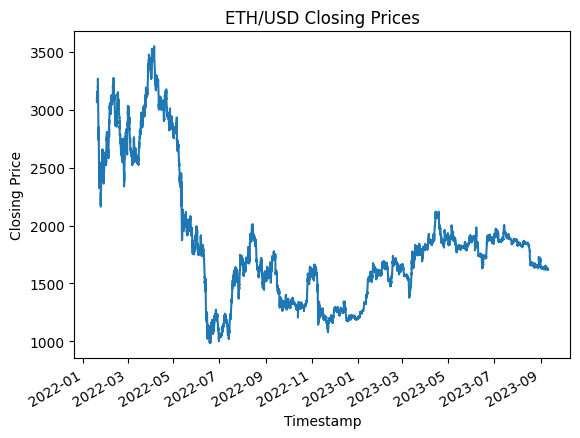

In [5]:
# plot closing prices
signals_df['close'].plot(title=f'{ticker} Closing Prices', xlabel="Timestamp", ylabel='Closing Price')
# plt.savefig(f'{ticker}_closing_prices', facecolor='white', edgecolor='white', transparent='false')

### Add Features (Techincal Analysis Indicators) to the DataFrame

In [6]:
# continuous features (techinal indicators) may be used
features = ["volume", "trade_count", "vwap", "9EMA", "20EMA", "50EMA", "200SMA", "ATR", "RSI", "BB_UPPER", "BB_LOWER", "MACD"]

#  Setup EMAs for crosses
longest_MA_window = 200
signals_df["9EMA"] = TA.EMA(signals_df, 9)
signals_df["20EMA"] = TA.EMA(signals_df, 20)
signals_df["50EMA"] = TA.EMA(signals_df, 50)
signals_df["200SMA"] = TA.SMA(signals_df, longest_MA_window)

# Setup Indicators
signals_df["ATR"] = TA.ATR(signals_df)
bbands_df = TA.BBANDS(signals_df)
macd_df = TA.MACD(signals_df)
signals_df["RSI"] = TA.RSI(signals_df)

# join macd and bbands Dataframes to signals_df
bbands_df = pd.concat([bbands_df, macd_df], axis=1)
signals_df = pd.concat([signals_df, bbands_df], axis=1)
signals_df.drop(columns="SIGNAL", inplace=True)

# Exit is the labeled target for ML, Exit Price is for use in Pnl Metrics
signals_df["Exit Price"] = 0
signals_df["Exit"] = 0

# Review DataFrame
signals_df

C:\Users\range\AppData\Local\Temp\ipykernel_16484\1529371452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["9EMA"] = TA.EMA(signals_df, 9)
C:\Users\range\AppData\Local\Temp\ipykernel_16484\1529371452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signals_df["20EMA"] = TA.EMA(signals_df, 20)
C:\Users\range\AppData\Local\Temp\ipykernel_16484\1529371452.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,symbol,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,,
2022-01-19 09:30:00+00:00,ETH/USD,3075.0600,3078.2000,3073.3100,3076.0300,54.69799,70.0,3074.823433,3076.030000,3076.030000,3076.030000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0
2022-01-19 09:35:00+00:00,ETH/USD,3074.5500,3076.7400,3072.8000,3076.7400,16.81543,67.0,3074.591751,3076.424444,3076.402750,3076.392100,NaN,NaN,100.000000,NaN,NaN,NaN,0.015929,0,0
2022-01-19 09:40:00+00:00,ETH/USD,3076.3800,3088.2900,3076.3800,3083.7700,18.04736,74.0,3084.672717,3079.434918,3079.107960,3078.950415,NaN,NaN,100.000000,NaN,NaN,NaN,0.238297,0,0
2022-01-19 09:45:00+00:00,ETH/USD,3083.4100,3086.7100,3079.0000,3082.8000,6.35700,35.0,3082.678425,3080.574851,3080.173795,3079.971309,NaN,NaN,88.039533,NaN,NaN,NaN,0.298573,0,0
2022-01-19 09:50:00+00:00,ETH/USD,3082.4900,3086.2000,3082.3700,3085.1300,1.65183,15.0,3083.165435,3081.929905,3081.372659,3081.087203,NaN,NaN,90.865672,NaN,NaN,NaN,0.417756,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10 15:40:00+00:00,ETH/USD,1619.0115,1619.9910,1619.0115,1619.6900,0.00000,0.0,0.000000,1618.891976,1620.430708,1622.871486,1628.896158,2.346321,45.327646,1628.326769,1621.073925,1613.821081,-1.800880,0,0
2023-09-10 15:45:00+00:00,ETH/USD,1620.4690,1620.4690,1618.8300,1618.8300,0.00000,0.0,0.000000,1618.879581,1620.278260,1622.712997,1628.858758,2.289036,43.034225,1627.508771,1620.684775,1613.860779,-1.704932,0,0
2023-09-10 15:50:00+00:00,ETH/USD,1618.8575,1619.9895,1618.7470,1619.2995,0.00000,0.0,0.000000,1618.963565,1620.185044,1622.579134,1628.818123,2.247357,44.679832,1626.586445,1620.323250,1614.060055,-1.572877,0,0


In [7]:
# Define NYSE regular trading hours
nyse_opening_time = pd.Timestamp("09:30:00")
nyse_closing_time = pd.Timestamp("16:00:00")

# Filter the DataFrame to include only data within NYSE regular trading hours
signals_df = signals_df.between_time(nyse_opening_time.time(), nyse_closing_time.time())

# Review DataFrame
signals_df

,symbol,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,,
2022-01-19 09:30:00+00:00,ETH/USD,3075.0600,3078.2000,3073.3100,3076.0300,54.69799,70.0,3074.823433,3076.030000,3076.030000,3076.030000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0
2022-01-19 09:35:00+00:00,ETH/USD,3074.5500,3076.7400,3072.8000,3076.7400,16.81543,67.0,3074.591751,3076.424444,3076.402750,3076.392100,NaN,NaN,100.000000,NaN,NaN,NaN,0.015929,0,0
2022-01-19 09:40:00+00:00,ETH/USD,3076.3800,3088.2900,3076.3800,3083.7700,18.04736,74.0,3084.672717,3079.434918,3079.107960,3078.950415,NaN,NaN,100.000000,NaN,NaN,NaN,0.238297,0,0
2022-01-19 09:45:00+00:00,ETH/USD,3083.4100,3086.7100,3079.0000,3082.8000,6.35700,35.0,3082.678425,3080.574851,3080.173795,3079.971309,NaN,NaN,88.039533,NaN,NaN,NaN,0.298573,0,0
2022-01-19 09:50:00+00:00,ETH/USD,3082.4900,3086.2000,3082.3700,3085.1300,1.65183,15.0,3083.165435,3081.929905,3081.372659,3081.087203,NaN,NaN,90.865672,NaN,NaN,NaN,0.417756,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10 15:40:00+00:00,ETH/USD,1619.0115,1619.9910,1619.0115,1619.6900,0.00000,0.0,0.000000,1618.891976,1620.430708,1622.871486,1628.896158,2.346321,45.327646,1628.326769,1621.073925,1613.821081,-1.800880,0,0
2023-09-10 15:45:00+00:00,ETH/USD,1620.4690,1620.4690,1618.8300,1618.8300,0.00000,0.0,0.000000,1618.879581,1620.278260,1622.712997,1628.858758,2.289036,43.034225,1627.508771,1620.684775,1613.860779,-1.704932,0,0
2023-09-10 15:50:00+00:00,ETH/USD,1618.8575,1619.9895,1618.7470,1619.2995,0.00000,0.0,0.000000,1618.963565,1620.185044,1622.579134,1628.818123,2.247357,44.679832,1626.586445,1620.323250,1614.060055,-1.572877,0,0


### Create Volatility Based Targets and Stops

In [8]:
# here we create the exit column, our "y", for use in supervised ML
# How many rows are in the signals_df? for use in modifying DataFrame
num_rows_in_df = signals_df.shape[0]

# reward:risk ratio
reward = 10
risk = 4

# we also figure out our exit price
# hitting target price before the stop price signals a win and will be 1
# hitting stop price before hitting the target price signals a loss and will be -1
# loop thru the dataframe, from the longest_MA_window to the end (num_rows_in_df) to avoid NaN values
for j in range(longest_MA_window, num_rows_in_df):
    # entries will be on candle close
    entry = signals_df["close"].iloc[j]
    # calculate volatility for each candle
    atr = signals_df["ATR"].iloc[j]
    # stop is entry price minus the average volatility for the entry period
    stop = entry - (risk * atr)
    # target is entry price plus the average volatility for the entry period times a multiplier
    target = entry + (reward * atr)
    # loop again thru the dataset to compare j entry price to future closing prices to see if we hit target or stop
    for k in range(j + 1, num_rows_in_df):
        # current low of the candle
        curr_low = signals_df["low"].iloc[k]
        # current high of the candle
        curr_high = signals_df["high"].iloc[k]
        # record and break if we hit stop or target, if not we check the next k period
        # if current low breaks our stop we should've sold: -1 in our "Exit" column
        if curr_low <= stop:
            signals_df.iloc[j, -2] = stop
            signals_df.iloc[j, -1] = -1
            # if we hit the stop break the inner loop to check the next row
            break
        # if current high breaks our target we should've sold: +1 in our "Exit" column
        elif curr_high >= target:
            signals_df.iloc[j, -2] = target
            signals_df.iloc[j, -1] = 1
            # if we hit the target break the inner loop to check the next row
            break

# drop beginning columns to avoid NaN values from EMA/SMA calculations
signals_df = signals_df[longest_MA_window:]

signals_df

C:\Users\range\AppData\Local\Temp\ipykernel_16484\897847839.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2699.655714285714' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_df.iloc[j, -2] = stop


,symbol,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,,
2022-01-21 13:00:00+00:00,ETH/USD,2777.2700,2794.0300,2773.6600,2793.7900,114.48341,261.0,2784.287740,2782.508086,2808.592328,2892.541903,3079.075050,23.533571,40.992481,2883.586598,2810.286000,2736.985402,-36.559030,2699.655714,-1
2022-01-21 13:05:00+00:00,ETH/USD,2794.0300,2800.2300,2777.4600,2783.9500,58.18724,230.0,2789.417050,2782.796469,2806.245440,2888.282079,3077.611100,24.030000,38.994138,2877.640913,2806.702500,2735.764087,-34.246007,2687.830000,-1
2022-01-21 13:10:00+00:00,ETH/USD,2783.7600,2789.3900,2769.1100,2786.8900,75.08059,231.0,2776.750521,2783.615175,2804.402065,2884.304737,3076.126700,24.144286,39.936277,2873.925277,2804.118500,2734.311723,-31.809012,2690.312857,-1
2022-01-21 13:15:00+00:00,ETH/USD,2786.8500,2791.1800,2777.7300,2788.3600,42.93291,166.0,2785.934526,2784.564140,2802.874249,2880.541124,3074.654500,23.150714,40.431629,2867.654766,2801.029000,2734.403234,-29.419925,2695.757143,-1
2022-01-21 13:20:00+00:00,ETH/USD,2790.2200,2795.5400,2782.3600,2784.8500,124.31559,228.0,2790.060151,2784.621312,2801.157654,2876.787501,3073.153100,23.613571,39.592007,2860.538795,2797.763000,2734.987205,-27.492863,2690.395714,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10 15:40:00+00:00,ETH/USD,1619.0115,1619.9910,1619.0115,1619.6900,0.00000,0.0,0.000000,1618.891976,1620.430708,1622.871486,1628.896158,2.346321,45.327646,1628.326769,1621.073925,1613.821081,-1.800880,0.000000,0
2023-09-10 15:45:00+00:00,ETH/USD,1620.4690,1620.4690,1618.8300,1618.8300,0.00000,0.0,0.000000,1618.879581,1620.278260,1622.712997,1628.858758,2.289036,43.034225,1627.508771,1620.684775,1613.860779,-1.704932,0.000000,0
2023-09-10 15:50:00+00:00,ETH/USD,1618.8575,1619.9895,1618.7470,1619.2995,0.00000,0.0,0.000000,1618.963565,1620.185044,1622.579134,1628.818123,2.247357,44.679832,1626.586445,1620.323250,1614.060055,-1.572877,0.000000,0


### Data Cleaning

In [9]:
# remove all unwanted zeros from the exit column
signals_df = signals_df.loc[signals_df["Exit"] != 0]

# # include only higher than average volume
# signals_df = signals_df[signals_df["volume"] >= signals_df["volume"].mean()]

# make sure we have a sufficient training period
training_begin = str(signals_df.index.min())
training_end = str(signals_df.index.min() + DateOffset(months=6))

signals_df

,symbol,open,high,low,close,volume,trade_count,vwap,9EMA,20EMA,50EMA,200SMA,ATR,RSI,BB_UPPER,BB_MIDDLE,BB_LOWER,MACD,Exit Price,Exit
timestamp,,,,,,,,,,,,,,,,,,,,
2022-01-21 13:00:00+00:00,ETH/USD,2777.2700,2794.030,2773.660,2793.7900,114.48341,261.0,2784.287740,2782.508086,2808.592328,2892.541903,3079.075050,23.533571,40.992481,2883.586598,2810.286000,2736.985402,-36.559030,2699.655714,-1
2022-01-21 13:05:00+00:00,ETH/USD,2794.0300,2800.230,2777.460,2783.9500,58.18724,230.0,2789.417050,2782.796469,2806.245440,2888.282079,3077.611100,24.030000,38.994138,2877.640913,2806.702500,2735.764087,-34.246007,2687.830000,-1
2022-01-21 13:10:00+00:00,ETH/USD,2783.7600,2789.390,2769.110,2786.8900,75.08059,231.0,2776.750521,2783.615175,2804.402065,2884.304737,3076.126700,24.144286,39.936277,2873.925277,2804.118500,2734.311723,-31.809012,2690.312857,-1
2022-01-21 13:15:00+00:00,ETH/USD,2786.8500,2791.180,2777.730,2788.3600,42.93291,166.0,2785.934526,2784.564140,2802.874249,2880.541124,3074.654500,23.150714,40.431629,2867.654766,2801.029000,2734.403234,-29.419925,2695.757143,-1
2022-01-21 13:20:00+00:00,ETH/USD,2790.2200,2795.540,2782.360,2784.8500,124.31559,228.0,2790.060151,2784.621312,2801.157654,2876.787501,3073.153100,23.613571,39.592007,2860.538795,2797.763000,2734.987205,-27.492863,2690.395714,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-10 14:35:00+00:00,ETH/USD,1623.2430,1623.243,1621.274,1621.2740,0.00000,0.0,0.000000,1624.538019,1625.058150,1625.596199,1629.304047,1.553107,32.289433,1628.277846,1625.228950,1622.180054,-0.323536,1615.061571,-1
2023-09-10 14:40:00+00:00,ETH/USD,1621.9485,1623.100,1621.481,1621.5575,0.00000,0.0,0.000000,1623.941915,1624.724754,1625.437819,1629.282735,1.554714,34.004632,1628.513851,1625.050175,1621.586499,-0.558504,1615.338643,-1
2023-09-10 14:45:00+00:00,ETH/USD,1622.1300,1622.829,1621.650,1622.8290,0.00000,0.0,0.000000,1623.719332,1624.544206,1625.335512,1629.272830,1.452679,41.198972,1628.555400,1624.952575,1621.349750,-0.634801,1617.018286,-1


In [10]:
signals_df.to_csv("cleaned_data.csv", index=True)

### Split the data into training and testing sets.

In [11]:
# choose features
X = signals_df[features]

# 1 means a buy would've produced a profit (hit target/win), -1 means a sale would've produced a profit (his stop/loss)
y = signals_df["Exit"]
y.head()

timestamp
2022-01-21 13:00:00+00:00   -1
2022-01-21 13:05:00+00:00   -1
2022-01-21 13:10:00+00:00   -1
2022-01-21 13:15:00+00:00   -1
2022-01-21 13:20:00+00:00   -1
Name: Exit, dtype: int64

In [12]:
# Splitting into Train and Test sets
X_train = X.loc[training_begin: training_end]
y_train = y.loc[training_begin: training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [13]:
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
# Undersample the data
rus = RandomUnderSampler(random_state=1)
undersampled_X_train_scaled, undersampled_y_train = rus.fit_resample(X_train_scaled, y_train)

### Support Vector Machine (SVC) Model

In [15]:
# Create the classifier model
model = svm.SVC(probability=True, random_state=1)
 
# Fit the model to the data using undersampled_X_train_scaled and undersampled_y_train
model = model.fit(undersampled_X_train_scaled, undersampled_y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = model.predict(undersampled_X_train_scaled)
training_probability_estimates = model.predict_proba(undersampled_X_train_scaled)

In [16]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'AAPL_5MIN_10TO4_SVM.pkl')

['AAPL_5MIN_10TO4_SVM.pkl']

In [17]:
# Save the X_Scaler
joblib.dump(X_scaler, "X_scaler.save") 

['X_scaler.save']

In [18]:
# Evaluate the model using a classification report
training_report = classification_report(undersampled_y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

          -1       0.65      0.59      0.62      4249
           1       0.62      0.68      0.65      4249

    accuracy                           0.64      8498
   macro avg       0.64      0.64      0.63      8498
weighted avg       0.64      0.64      0.63      8498



In [19]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)
testing_probability_estimates = model.predict_proba(X_test_scaled)

In [20]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

          -1       0.76      0.13      0.23     23670
           1       0.29      0.89      0.43      9152

    accuracy                           0.35     32822
   macro avg       0.52      0.51      0.33     32822
weighted avg       0.63      0.35      0.28     32822



### Visualization

In [21]:
# Create a predictions DataFrame for SVM
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = signals_df["close"].pct_change()

predictions_df["algo_returns"] = (signals_df["Exit Price"] - signals_df["close"])/signals_df["close"]


predictions_df["trading_algorithm_returns"] = (
    predictions_df["algo_returns"] * predictions_df["predicted_signal"]
)

predictions_df = predictions_df.drop(columns=["algo_returns"])

predictions_df["probability_estimates"] = testing_probability_estimates[:, 1]

# Filter rows where the predicted signal is 1 and the probability estimate is >= 0.60
buy_signals_df = predictions_df[(predictions_df["predicted_signal"] == 1) & (predictions_df["probability_estimates"] >= 0.50)]


### Evaluation Metrics

In [22]:
# Calculate the time period for which you want to calculate the frequency (e.g., in days)
start_date = buy_signals_df.index.min()
end_date = buy_signals_df.index.max()
time_period_days = (end_date - start_date).days + 1  # Adding 1 to include both start and end dates

# Filter the winning, losing, and total trades
winning_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]
losing_trades = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]
total_trades = buy_signals_df["trading_algorithm_returns"]

# Calculate gross profit (positive returns) and gross loss (negative returns)
gross_profit = buy_signals_df[buy_signals_df['trading_algorithm_returns'] > 0]['trading_algorithm_returns'].sum() * 100
gross_loss = buy_signals_df[buy_signals_df['trading_algorithm_returns'] < 0]['trading_algorithm_returns'].sum() * 100

# Calculate the average return of your trading strategy
average_return = buy_signals_df['trading_algorithm_returns'].mean()

# Calculate the risk-free rate (e.g., Treasury bill rate)
# You need to specify an appropriate risk-free rate for your analysis
risk_free_rate = 0.02  # Replace with the risk-free rate you want to use (e.g., 2% for a Treasury bill)

# Calculate downside returns (negative returns)
downside_returns = buy_signals_df['trading_algorithm_returns'][buy_signals_df['trading_algorithm_returns'] < 0]

# Calculate the downside deviation (standard deviation of negative returns)
downside_deviation = (downside_returns * 100).std()

# Calculate the Risk:Reward Ratio
risk_reward_ratio= reward/risk

# Calculate the win rate (if you haven't already)
win_rate = len(winning_trades) / len(total_trades)

# Calculate the profit factor
profit_factor = abs(gross_profit / gross_loss)

# Calculate the Sortino Ratio
sortino_ratio = (average_return - risk_free_rate) / downside_deviation

# Calculate the average profit per winning trade
average_profit_per_winning_trade = winning_trades['trading_algorithm_returns'].mean()

# Calculate the average loss per losing trade
average_loss_per_losing_trade = losing_trades['trading_algorithm_returns'].mean()

# Calculate the trade frequency (trades per day)
trade_frequency_per_day = len(total_trades) / time_period_days

# Calculate the volatility of your trading strategy's returns
algo_volatility = buy_signals_df['trading_algorithm_returns'].std()

# Calculate the cumulative returns of the algo
cumulative_returns = ( 1 + buy_signals_df['trading_algorithm_returns']).sum()

# Print the sorted metrics by importance
print("Risk:Reward Ratio:", risk_reward_ratio)
print("Win Rate (%):", win_rate * 100)
print("Profit Factor:", profit_factor)
print("Sortino Ratio:", sortino_ratio)
print("Average Profit per Winning Trade (%):", average_profit_per_winning_trade * 100)
print("Average Loss per Losing Trade (%):", average_loss_per_losing_trade * 100)
print("Average Return (%):", average_return * 100)
print("Trade Frequency (Trades per Day):", trade_frequency_per_day)
print("Downside Deviation:", downside_deviation)
print("Volatility (Standard Deviation of Algo Returns):", algo_volatility)
print("Gross Profit (%):", gross_profit)
print("Gross Loss (%):", gross_loss)
print("Total Number of Winning Trades:", len(winning_trades))
print("Total Number of Trades:", len(total_trades))
print("Risk-Free Rate (%):", risk_free_rate * 100)


Risk:Reward Ratio: 2.5
Win Rate (%): 28.453935757147903
Profit Factor: 1.0751960456339658
Sortino Ratio: -0.03249792564209046
Average Profit per Winning Trade (%): 2.478077334851898
Average Loss per Losing Trade (%): -0.9166083211752489
Average Return (%): 0.049313354547830104
Trade Frequency (Trades per Day): 67.93764988009592
Downside Deviation: 0.6002495872923322
Volatility (Standard Deviation of Algo Returns): 0.018145100730440365
Gross Profit (%): 19975.78139624115
Gross Loss (%): -18578.73406190112
Total Number of Winning Trades: 8061
Total Number of Trades: 28330
Risk-Free Rate (%): 2.0


### WIP METRICS

In [23]:
# maximum drawdown (MDD)
# peters ratio
# t-stat
# kelly criterion
# sharpe ratio
# calmar ratio
# pain/gain ratio
# ulcer index
# k-ratio


C:\Users\range\AppData\Local\Temp\ipykernel_16484\582182051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_signals_df.loc[:, "Cumulative Algo Returns"] = (1 + buy_signals_df.loc[:, "trading_algorithm_returns"]).cumprod()


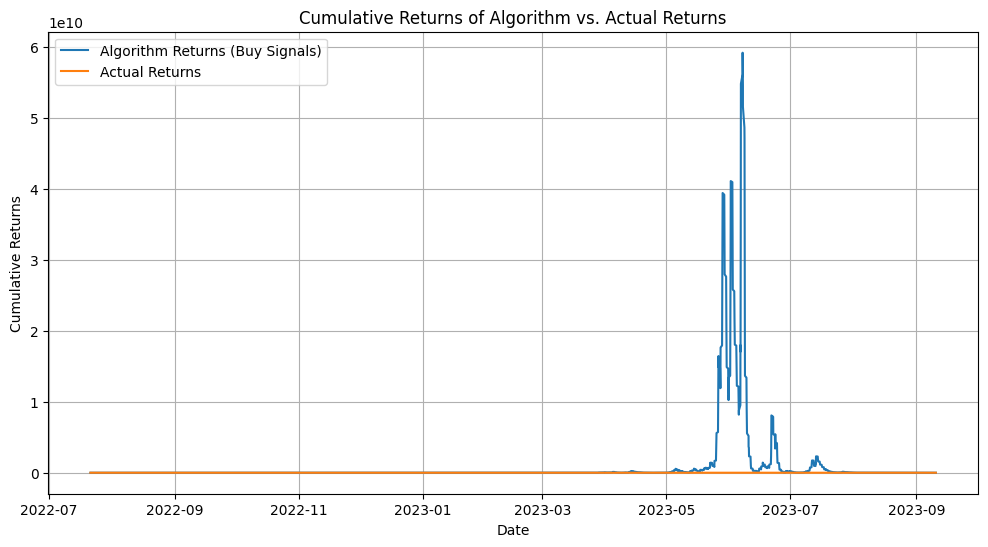

In [24]:
# Calculate cumulative returns for the algorithmic trading strategy
buy_signals_df.loc[:, "Cumulative Algo Returns"] = (1 + buy_signals_df.loc[:, "trading_algorithm_returns"]).cumprod()

# Calculate cumulative returns for the actual stock returns
predictions_df.loc[:, "Cumulative Actual Returns"] = (1 + predictions_df.loc[:, "actual_returns"]).cumprod()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(buy_signals_df.index, buy_signals_df["Cumulative Algo Returns"], label="Algorithm Returns (Buy Signals)")
plt.plot(predictions_df.index, predictions_df["Cumulative Actual Returns"], label="Actual Returns")
plt.xlabel("Date") 
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns of Algorithm vs. Actual Returns")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
buy_signals_df

,predicted_signal,actual_returns,trading_algorithm_returns,probability_estimates,Cumulative Algo Returns
timestamp,,,,,
2022-07-21 13:00:00+00:00,1,-0.002915,0.051972,0.612621,1.051972
2022-07-21 13:05:00+00:00,1,-0.001771,0.053174,0.584365,1.107910
2022-07-21 13:10:00+00:00,1,-0.001768,0.053302,0.550965,1.166963
2022-07-21 13:15:00+00:00,1,-0.000949,0.051575,0.522109,1.227149
2022-07-21 13:20:00+00:00,1,0.003806,0.050989,0.601504,1.289721
...,...,...,...,...,...
2023-09-10 14:30:00+00:00,1,-0.000803,-0.003675,0.566408,12233.363278
2023-09-10 14:40:00+00:00,1,0.000175,-0.003835,0.509682,12186.446941
2023-09-10 14:45:00+00:00,1,0.000784,-0.003581,0.572489,12142.812053


In [26]:
import pandas as pd

# Assuming your dataframe is named 'buy_signals_df'
# Step 2: Calculate cumulative returns
buy_signals_df['cumulative_returns'] = (1 + buy_signals_df['trading_algorithm_returns']).cumprod()

# Step 3: Calculate the peak
buy_signals_df['peak'] = buy_signals_df['cumulative_returns'].cummax()

# Step 4: Calculate drawdown
buy_signals_df['drawdown'] = buy_signals_df['cumulative_returns'] / buy_signals_df['peak'] - 1

# Step 5: Find the maximum drawdown
max_drawdown = buy_signals_df['drawdown'].min()

print("Maximum Drawdown (MDD): {:.2%}".format(max_drawdown))


Maximum Drawdown (MDD): -100.00%


C:\Users\range\AppData\Local\Temp\ipykernel_16484\958304416.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_signals_df['cumulative_returns'] = (1 + buy_signals_df['trading_algorithm_returns']).cumprod()
C:\Users\range\AppData\Local\Temp\ipykernel_16484\958304416.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_signals_df['peak'] = buy_signals_df['cumulative_returns'].cummax()
C:\Users\range\AppData\Local\Temp\ipykernel_16484\958304416.py:11: SettingWithCopyWarning: 
A value is trying to be se

In [27]:
# Calculate Kelly Criterion
kelly_criterion = (win_rate * (average_profit_per_winning_trade / abs(average_loss_per_losing_trade))) - ((1 - win_rate) / abs(average_loss_per_losing_trade))

# Calculate Sharpe Ratio (assuming a risk-free rate has already been defined)
sharpe_ratio = (average_return - risk_free_rate) / algo_volatility

# # Calculate Calmar Ratio
# calmar_ratio = (average_return - risk_free_rate) / (drawdown_max / 100)

# Calculate Pain/Gain Ratio
pain_gain_ratio = (average_loss_per_losing_trade * win_rate) / (average_profit_per_winning_trade * (1 - win_rate))

print(kelly_criterion, sharpe_ratio, pain_gain_ratio)

-77.28595963339136 -1.075048672603775 -0.14710435782582515


In [28]:
import pandas as pd

df2 = pd.DataFrame([{'Risk': 1, 'Reward': 1, 'Win Rate (%)': 51.68067226890757, 'Profit Factor': 1.0733808813416092, 'Cumulative Returns': 1.6981633887097984, 'Sortino Ratio': -0.14363021901285425, 'Average Profit per Winning Trade (%)': 0.19316427176882509, 'Average Loss per Losing Trade (%)': -0.192477609689141, 'Average Return (%)': 0.006824707198799467, 'Trade Frequency (Trades per Day)': 19.4052757793765, 'Downside Deviation': 0.1387713049872061, 'Volatility (Standard Deviation of Algo Returns)': 0.002368281480211426, 'Gross Profit (%)': 807.8129845372265, 'Gross Loss (%)': -752.5874538845412, 'Total Number of Winning Trades': 4182, 'Total Number of Trades': 8092, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 1, 'Reward': 2, 'Win Rate (%)': 35.77304621340431, 'Profit Factor': 1.05958611909491, 'Cumulative Returns': 1.7267841361193652, 'Sortino Ratio': -0.1520338826163541, 'Average Profit per Winning Trade (%)': 0.35362932527676333, 'Average Loss per Losing Trade (%)': -0.1858876817721641, 'Average Return (%)': 0.007113986488624433, 'Trade Frequency (Trades per Day)': 19.587677725118482, 'Downside Deviation': 0.13108170226371654, 'Volatility (Standard Deviation of Algo Returns)': 0.0031827184215105254, 'Gross Profit (%)': 1045.681914843389, 'Gross Loss (%)': -986.8777025284193, 'Total Number of Winning Trades': 2957, 'Total Number of Trades': 8266, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.0}, {'Risk': 1, 'Reward': 3, 'Win Rate (%)': 27.78675282714055, 'Profit Factor': 1.100286720777277, 'Cumulative Returns': 2.752065555429843, 'Sortino Ratio': -0.14672493598180517, 'Average Profit per Winning Trade (%)': 0.5733131099406654, 'Average Loss per Losing Trade (%)': -0.20049655975417627, 'Average Return (%)': 0.014520020516442102, 'Trade Frequency (Trades per Day)': 17.601895734597157, 'Downside Deviation': 0.13531987362596432, 'Volatility (Standard Deviation of Algo Returns)': 0.004230218052636733, 'Gross Profit (%)': 1183.3182589175333, 'Gross Loss (%)': -1075.4635465214014, 'Total Number of Winning Trades': 2064, 'Total Number of Trades': 7428, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 3.0}, {'Risk': 1, 'Reward': 4, 'Win Rate (%)': 22.463641142456634, 'Profit Factor': 1.146807347147665, 'Cumulative Returns': 9.129773001813188, 'Sortino Ratio': -0.1595430374572503, 'Average Profit per Winning Trade (%)': 0.7098245687907394, 'Average Loss per Losing Trade (%)': -0.17932271714677295, 'Average Return (%)': 0.020412138394122568, 'Trade Frequency (Trades per Day)': 27.11163895486936, 'Downside Deviation': 0.12407861183765603, 'Volatility (Standard Deviation of Algo Returns)': 0.0045651670230988425, 'Gross Profit (%)': 1819.9901943794557, 'Gross Loss (%)': -1587.0060467489407, 'Total Number of Winning Trades': 2564, 'Total Number of Trades': 11414, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 4.0}, {'Risk': 1, 'Reward': 5, 'Win Rate (%)': 18.91391794046661, 'Profit Factor': 1.1842010602338142, 'Cumulative Returns': 19.21339421429835, 'Sortino Ratio': -0.17483071153284377, 'Average Profit per Winning Trade (%)': 0.8478347760969701, 'Average Loss per Losing Trade (%)': -0.16700172789727055, 'Average Return (%)': 0.0249436156981003, 'Trade Frequency (Trades per Day)': 29.879807692307693, 'Downside Deviation': 0.11296964743696446, 'Volatility (Standard Deviation of Algo Returns)': 0.004843899143568176, 'Gross Profit (%)': 1993.2595586039768, 'Gross Loss (%)': -1683.21041547659, 'Total Number of Winning Trades': 2351, 'Total Number of Trades': 12430, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 5.0}, {'Risk': 1, 'Reward': 6, 'Win Rate (%)': 15.983054111303677, 'Profit Factor': 1.1266067235604857, 'Cumulative Returns': 6.110771001826533, 'Sortino Ratio': -0.1688073791475524, 'Average Profit per Winning Trade (%)': 1.0516066737430287, 'Average Loss per Losing Trade (%)': -0.17757174977204826, 'Average Return (%)': 0.01888850278283601, 'Trade Frequency (Trades per Day)': 24.906474820143885, 'Downside Deviation': 0.11735929479039536, 'Volatility (Standard Deviation of Algo Returns)': 0.005431757528649323, 'Gross Profit (%)': 1745.6670784134278, 'Gross Loss (%)': -1549.491088510893, 'Total Number of Winning Trades': 1660, 'Total Number of Trades': 10386, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 6.0}, {'Risk': 1, 'Reward': 7, 'Win Rate (%)': 13.468958260259559, 'Profit Factor': 1.117209629262293, 'Cumulative Returns': 6.74488962748203, 'Sortino Ratio': -0.16794699002800184, 'Average Profit per Winning Trade (%)': 1.3153326431011594, 'Average Loss per Losing Trade (%)': -0.18325802547982284, 'Average Return (%)': 0.018586526163494318, 'Trade Frequency (Trades per Day)': 27.814634146341465, 'Downside Deviation': 0.11797850461661409, 'Volatility (Standard Deviation of Algo Returns)': 0.006119342420482885, 'Gross Profit (%)': 2020.350939803381, 'Gross Loss (%)': -1808.3901954348917, 'Total Number of Winning Trades': 1536, 'Total Number of Trades': 11404, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 7.0}, {'Risk': 1, 'Reward': 8, 'Win Rate (%)': 11.29889859475883, 'Profit Factor': 1.0211034557736671, 'Cumulative Returns': 1.1681295019708415, 'Sortino Ratio': -0.18094208414035765, 'Average Profit per Winning Trade (%)': 1.2859914590404409, 'Average Loss per Losing Trade (%)': -0.1604262517614647, 'Average Return (%)': 0.0030030186386746766, 'Trade Frequency (Trades per Day)': 25.37831325301205, 'Downside Deviation': 0.11036663973717939, 'Volatility (Standard Deviation of Algo Returns)': 0.0055682311396454435, 'Gross Profit (%)': 1530.3298362581245, 'Gross Loss (%)': -1498.702043955603, 'Total Number of Winning Trades': 1190, 'Total Number of Trades': 10532, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 8.0}, {'Risk': 1, 'Reward': 9, 'Win Rate (%)': 9.97675319643549, 'Profit Factor': 1.0421426081700698, 'Cumulative Returns': 1.5578357787092199, 'Sortino Ratio': -0.18190396489322677, 'Average Profit per Winning Trade (%)': 1.5257217293710597, 'Average Loss per Losing Trade (%)': -0.16224926407266865, 'Average Return (%)': 0.0061554359706324, 'Trade Frequency (Trades per Day)': 25.180487804878048, 'Downside Deviation': 0.10960973639028188, 'Volatility (Standard Deviation of Algo Returns)': 0.0061560588273859105, 'Gross Profit (%)': 1571.4933812521913, 'Gross Loss (%)': -1507.9446602913827, 'Total Number of Winning Trades': 1030, 'Total Number of Trades': 10324, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 9.0}, {'Risk': 1, 'Reward': 10, 'Win Rate (%)': 9.25785527756718, 'Profit Factor': 1.1177128345711183, 'Cumulative Returns': 6.923804356871475, 'Sortino Ratio': -0.16977017227231853, 'Average Profit per Winning Trade (%)': 1.9421598768013533, 'Average Loss per Losing Trade (%)': -0.17727850781623858, 'Average Return (%)': 0.018936030528865725, 'Trade Frequency (Trades per Day)': 28.604819277108433, 'Downside Deviation': 0.1166909323914347, 'Volatility (Standard Deviation of Algo Returns)': 0.007335378575907445, 'Gross Profit (%)': 2134.4337046046876, 'Gross Loss (%)': -1909.644086196522, 'Total Number of Winning Trades': 1099, 'Total Number of Trades': 11871, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 10.0}, {'Risk': 2, 'Reward': 1, 'Win Rate (%)': 68.69128249945379, 'Profit Factor': 1.1209493771506291, 'Cumulative Returns': 4.019103059638137, 'Sortino Ratio': -0.07157980981951251, 'Average Profit per Winning Trade (%)': 0.21330034380778626, 'Average Loss per Losing Trade (%)': -0.41748598657170116, 'Average Return (%)': 0.015809233597210474, 'Trade Frequency (Trades per Day)': 21.691943127962084, 'Downside Deviation': 0.2771997818108065, 'Volatility (Standard Deviation of Algo Returns)': 0.0034939938262840238, 'Gross Profit (%)': 1341.23256186336, 'Gross Loss (%)': -1196.5148375144954, 'Total Number of Winning Trades': 6288, 'Total Number of Trades': 9154, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.5}, {'Risk': 2, 'Reward': 2, 'Win Rate (%)': 53.1588132635253, 'Profit Factor': 1.1237644260201742, 'Cumulative Returns': 6.983067343491182, 'Sortino Ratio': -0.07510792652208369, 'Average Profit per Winning Trade (%)': 0.40639253140459364, 'Average Loss per Losing Trade (%)': -0.4104098973417249, 'Average Return (%)': 0.023792580487469902, 'Trade Frequency (Trades per Day)': 20.36729857819905, 'Downside Deviation': 0.26311569377853533, 'Volatility (Standard Deviation of Algo Returns)': 0.0048546199762111554, 'Gross Profit (%)': 1856.8074759875885, 'Gross Loss (%)': -1652.3102466977846, 'Total Number of Winning Trades': 4569, 'Total Number of Trades': 8595, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 2, 'Reward': 3, 'Win Rate (%)': 45.64673789497613, 'Profit Factor': 1.2469617844590983, 'Cumulative Returns': 119.99483207787554, 'Sortino Ratio': -0.0739975404278595, 'Average Profit per Winning Trade (%)': 0.6231401001186321, 'Average Loss per Losing Trade (%)': -0.41967846829690003, 'Average Return (%)': 0.05633419034788029, 'Trade Frequency (Trades per Day)': 21.098321342925658, 'Downside Deviation': 0.26266627220495353, 'Volatility (Standard Deviation of Algo Returns)': 0.006179535779189895, 'Gross Profit (%)': 2502.530642076427, 'Gross Loss (%)': -2006.9024353957757, 'Total Number of Winning Trades': 4016, 'Total Number of Trades': 8798, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.5}])

df2

,Risk,Reward,Win Rate (%),Profit Factor,Cumulative Returns,Sortino Ratio,Average Profit per Winning Trade (%),Average Loss per Losing Trade (%),Average Return (%),Trade Frequency (Trades per Day),Downside Deviation,Volatility (Standard Deviation of Algo Returns),Gross Profit (%),Gross Loss (%),Total Number of Winning Trades,Total Number of Trades,Risk-Free Rate (%),Risk:Reward Ratio
0,1,1,51.680672,1.073381,1.698163,-0.143630,0.193164,-0.192478,0.006825,19.405276,0.138771,0.002368,807.812985,-752.587454,4182,8092,2.0,1.0
1,1,2,35.773046,1.059586,1.726784,-0.152034,0.353629,-0.185888,0.007114,19.587678,0.131082,0.003183,1045.681915,-986.877703,2957,8266,2.0,2.0
2,1,3,27.786753,1.100287,2.752066,-0.146725,0.573313,-0.200497,0.014520,17.601896,0.135320,0.004230,1183.318259,-1075.463547,2064,7428,2.0,3.0
3,1,4,22.463641,1.146807,9.129773,-0.159543,0.709825,-0.179323,0.020412,27.111639,0.124079,0.004565,1819.990194,-1587.006047,2564,11414,2.0,4.0
4,1,5,18.913918,1.184201,19.213394,-0.174831,0.847835,-0.167002,0.024944,29.879808,0.112970,0.004844,1993.259559,-1683.210415,2351,12430,2.0,5.0
5,1,6,15.983054,1.126607,6.110771,-0.168807,1.051607,-0.177572,0.018889,24.906475,0.117359,0.005432,1745.667078,-1549.491089,1660,10386,2.0,6.0
6,1,7,13.468958,1.117210,6.744890,-0.167947,1.315333,-0.183258,0.018587,27.814634,0.117979,0.006119,2020.350940,-1808.390195,1536,11404,2.0,7.0
7,1,8,11.298899,1.021103,1.168130,-0.180942,1.285991,-0.160426,0.003003,25.378313,0.110367,0.005568,1530.329836,-1498.702044,1190,10532,2.0,8.0
8,1,9,9.976753,1.042143,1.557836,-0.181904,1.525722,-0.162249,0.006155,25.180488,0.109610,0.006156,1571.493381,-1507.944660,1030,10324,2.0,9.0
9,1,10,9.257855,1.117713,6.923804,-0.169770,1.942160,-0.177279,0.018936,28.604819,0.116691,0.007335,2134.433705,-1909.644086,1099,11871,2.0,10.0


In [29]:
df3 = pd.DataFrame([{'Risk': 3, 'Reward': 1, 'Win Rate (%)': 77.8505182760502, 'Profit Factor': 1.203715570032061, 'Cumulative Returns': 11.822006597759954, 'Sortino Ratio': -0.046839253796216444, 'Average Profit per Winning Trade (%)': 0.21113395363415885, 'Average Loss per Losing Trade (%)': -0.6164986666336241, 'Average Return (%)': 0.027817617666499383, 'Trade Frequency (Trades per Day)': 21.718009478672986, 'Downside Deviation': 0.42105333080537005, 'Volatility (Standard Deviation of Algo Returns)': 0.004146650940829134, 'Gross Profit (%)': 1506.4407591797237, 'Gross Loss (%)': -1251.4922932662569, 'Total Number of Winning Trades': 7135, 'Total Number of Trades': 9165, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.3333333333333333}, {'Risk': 3, 'Reward': 2, 'Win Rate (%)': 64.60946094609461, 'Profit Factor': 1.2172272320864916, 'Cumulative Returns': 51.20511169670716, 'Sortino Ratio': -0.04989418874686769, 'Average Profit per Winning Trade (%)': 0.3892823938383657, 'Average Loss per Losing Trade (%)': -0.5838510186193874, 'Average Return (%)': 0.04488523345590238, 'Trade Frequency (Trades per Day)': 21.540284360189574, 'Downside Deviation': 0.3918522007569144, 'Volatility (Standard Deviation of Algo Returns)': 0.0056104785174589675, 'Gross Profit (%)': 2286.255499012722, 'Gross Loss (%)': -1878.248726898569, 'Total Number of Winning Trades': 5873, 'Total Number of Trades': 9090, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 0.6666666666666666}, {'Risk': 3, 'Reward': 3, 'Win Rate (%)': 56.55839325564096, 'Profit Factor': 1.333831872648241, 'Cumulative Returns': 1216.990605482476, 'Sortino Ratio': -0.04846491342330071, 'Average Profit per Winning Trade (%)': 0.6420604356339619, 'Average Loss per Losing Trade (%)': -0.6267091011696977, 'Average Return (%)': 0.09088656296349037, 'Trade Frequency (Trades per Day)': 19.113744075829384, 'Downside Deviation': 0.3939166093957481, 'Volatility (Standard Deviation of Algo Returns)': 0.007448328661882918, 'Gross Profit (%)': 2929.079707362134, 'Gross Loss (%)': -2195.9886904986206, 'Total Number of Winning Trades': 4562, 'Total Number of Trades': 8066, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.0}, {'Risk': 3, 'Reward': 4, 'Win Rate (%)': 48.9613496160141, 'Profit Factor': 1.3303253870544738, 'Cumulative Returns': 3717.433244592763, 'Sortino Ratio': -0.04866670406301193, 'Average Profit per Winning Trade (%)': 0.884383350686972, 'Average Loss per Losing Trade (%)': -0.6377300445725529, 'Average Return (%)': 0.10751721643264571, 'Trade Frequency (Trades per Day)': 18.822274881516588, 'Downside Deviation': 0.3888660265788771, 'Volatility (Standard Deviation of Algo Returns)': 0.008919371326135978, 'Gross Profit (%)': 3439.366850821634, 'Gross Loss (%)': -2585.3576006971293, 'Total Number of Winning Trades': 3889, 'Total Number of Trades': 7943, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.3333333333333333}, {'Risk': 3, 'Reward': 5, 'Win Rate (%)': 44.91377155711072, 'Profit Factor': 1.3851483858603222, 'Cumulative Returns': 38468.73154278567, 'Sortino Ratio': -0.04836356807753073, 'Average Profit per Winning Trade (%)': 1.0984235144350671, 'Average Loss per Losing Trade (%)': -0.646561749333405, 'Average Return (%)': 0.1371769457408125, 'Trade Frequency (Trades per Day)': 18.96208530805687, 'Downside Deviation': 0.38517072422632903, 'Volatility (Standard Deviation of Algo Returns)': 0.010178804899092724, 'Gross Profit (%)': 3947.7341108796318, 'Gross Loss (%)': -2850.0441910616496, 'Total Number of Winning Trades': 3594, 'Total Number of Trades': 8002, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 1.6666666666666667}, {'Risk': 3, 'Reward': 6, 'Win Rate (%)': 41.127008032128515, 'Profit Factor': 1.4170141785150603, 'Cumulative Returns': 27413.417870999685, 'Sortino Ratio': -0.05254655287481603, 'Average Profit per Winning Trade (%)': 1.1002004119457576, 'Average Loss per Losing Trade (%)': -0.5423861808794576, 'Average Return (%)': 0.13316053908643477, 'Trade Frequency (Trades per Day)': 18.881516587677726, 'Downside Deviation': 0.35527344017428114, 'Volatility (Standard Deviation of Algo Returns)': 0.009869561208901546, 'Gross Profit (%)': 3605.3567499462483, 'Gross Loss (%)': -2544.3335745055356, 'Total Number of Winning Trades': 3277, 'Total Number of Trades': 7968, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.0}, {'Risk': 3, 'Reward': 7, 'Win Rate (%)': 37.343206891340486, 'Profit Factor': 1.3798810967175241, 'Cumulative Returns': 7213.183702688102, 'Sortino Ratio': -0.0535015281039731, 'Average Profit per Winning Trade (%)': 1.3681541255325065, 'Average Loss per Losing Trade (%)': -0.5909310453320537, 'Average Return (%)': 0.1406541832014703, 'Trade Frequency (Trades per Day)': 16.139024390243904, 'Downside Deviation': 0.34753134773742134, 'Volatility (Standard Deviation of Algo Returns)': 0.01129157964340588, 'Gross Profit (%)': 3380.7088441908236, 'Gross Loss (%)': -2450.0001139466945, 'Total Number of Winning Trades': 2471, 'Total Number of Trades': 6617, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.3333333333333335}, {'Risk': 3, 'Reward': 8, 'Win Rate (%)': 34.21616656460502, 'Profit Factor': 1.4298196794618128, 'Cumulative Returns': 28121.319732757576, 'Sortino Ratio': -0.05182295559683708, 'Average Profit per Winning Trade (%)': 1.6004115072472562, 'Average Loss per Losing Trade (%)': -0.5821870875922998, 'Average Return (%)': 0.1646144830547314, 'Trade Frequency (Trades per Day)': 15.93170731707317, 'Downside Deviation': 0.3541645774169793, 'Volatility (Standard Deviation of Algo Returns)': 0.012460948831190762, 'Gross Profit (%)': 3576.919718697618, 'Gross Loss (%)': -2501.657915384112, 'Total Number of Winning Trades': 2235, 'Total Number of Trades': 6532, 'Risk-Free Rate (%)': 2.0, 'Risk:Reward Ratio': 2.6666666666666665}])

df3

,Risk,Reward,Win Rate (%),Profit Factor,Cumulative Returns,Sortino Ratio,Average Profit per Winning Trade (%),Average Loss per Losing Trade (%),Average Return (%),Trade Frequency (Trades per Day),Downside Deviation,Volatility (Standard Deviation of Algo Returns),Gross Profit (%),Gross Loss (%),Total Number of Winning Trades,Total Number of Trades,Risk-Free Rate (%),Risk:Reward Ratio
0,3,1,77.850518,1.203716,11.822007,-0.046839,0.211134,-0.616499,0.027818,21.718009,0.421053,0.004147,1506.440759,-1251.492293,7135,9165,2.0,0.333333
1,3,2,64.609461,1.217227,51.205112,-0.049894,0.389282,-0.583851,0.044885,21.540284,0.391852,0.005610,2286.255499,-1878.248727,5873,9090,2.0,0.666667
2,3,3,56.558393,1.333832,1216.990605,-0.048465,0.642060,-0.626709,0.090887,19.113744,0.393917,0.007448,2929.079707,-2195.988690,4562,8066,2.0,1.000000
3,3,4,48.961350,1.330325,3717.433245,-0.048667,0.884383,-0.637730,0.107517,18.822275,0.388866,0.008919,3439.366851,-2585.357601,3889,7943,2.0,1.333333
4,3,5,44.913772,1.385148,38468.731543,-0.048364,1.098424,-0.646562,0.137177,18.962085,0.385171,0.010179,3947.734111,-2850.044191,3594,8002,2.0,1.666667
5,3,6,41.127008,1.417014,27413.417871,-0.052547,1.100200,-0.542386,0.133161,18.881517,0.355273,0.009870,3605.356750,-2544.333575,3277,7968,2.0,2.000000
6,3,7,37.343207,1.379881,7213.183703,-0.053502,1.368154,-0.590931,0.140654,16.139024,0.347531,0.011292,3380.708844,-2450.000114,2471,6617,2.0,2.333333
7,3,8,34.216167,1.429820,28121.319733,-0.051823,1.600412,-0.582187,0.164614,15.931707,0.354165,0.012461,3576.919719,-2501.657915,2235,6532,2.0,2.666667


In [30]:
import pandas as pd
import plotly.graph_objs as go

# Create a Figure with a Surface plot using the provided DataFrame
fig2 = go.Figure(data=[go.Surface(z=metrics_df.values)])

# Update the traces for contour lines
fig2.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

# # Update the layout
# fig.update_layout(title='3D Contour Plot', autosize=False,
#                   scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
#                   width=500, height=500,
#                   margin=dict(l=65, r=50, b=65, t=90)
# )

# Show the plot
fig2.show()


ModuleNotFoundError: No module named 'plotly'